# Barricelli's Game of Life

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Define the simulator

In [2]:
class Barricelli:
    """Barricelli's Game of Life.
    
    Described in detail in this paper:
    
    Barricelli, Nils Aall. Numerical testing of evolution theories. 
        Part I. Theoretical Introduction & Basic Tests. Acta Biotheoretica, vol. 16, nos 1-2, 69–98.
        
    Parameters
    ----------
    world_size : int
        Size of the ecosystem in pixels.
        
    gene_range : int
        Number of possible genes in the ecosystem.
        The same number of them (half) will be positive and  negative.
        Thus, the range of genes will be [-(gene_range // 2), gene_range // 2].
        
    propagation_rule : function
        A function which describes the propagation rule. It should take an index and a numpy array representing
        the current state as arguments and return the contribution of the gene at that index to the next generation, 
        in the form of a tuple of 2 lists of the same length containing indices in the first and values in the second.
        
    collision_rule : function
        A function which describes the collision rule. It should take a list of collisions and a numpy array 
        representing the current state and return the result of the collision in the next generation, in the 
        form of a tuple of 2 lists of the same length containing indices in the first and values in the second.
        
    init_time_steps : int, optional
        Number of time steps to allocate space for in history initially.
        Default is 1024.
        
    init_state : array, shape (world_size), optional
        Initial state of genes in the ecosystem.
        If None, initialization will be randomized.
        Default is None.
        
        
    """
    def __init__(self, world_size, gene_range, propagation_rule, collision_rule, init_time_steps=1024, init_state=None):
        self.world_size = world_size
        if gene_range % 2 == 0:
            self.gene_range = gene_range + 1
        else:
            self.gene_range = gene_range
        self.gene_min = -(gene_range // 2)
        self.gene_max = gene_range // 2
        self.propagation_rule = propagation_rule
        self.collision_rule = collision_rule
        self.history = np.zeros((init_time_steps, world_size), dtype=int)
        if init_state is None:
            self.history[0] = np.random.randint(self.gene_min, high=self.gene_max, size=world_size)
        else:
            self.history[0] = init_state
        self.init_state = self.history[0].view()
        self.time_step = 0
        self.time_step_jump = init_time_steps
        
    def evolve(self, n_time_steps=1):
        """Simulate evolution of the ecosystem from the current state.
        
        Parameters
        ----------
        n_time_steps : int, optional
            The number of steps to progress.
            Default is 1.
            
        """
        current_state = self.history[self.time_step].copy()
        for i in range(n_time_steps):
            collision_table = [[] for j in range(self.world_size)]
            for j in range(self.world_size):
                indices, values = self.propagation_rule(j, current_state)
                for idx, val in zip(indices, values):
                    if val != 0:
                        collision_table[idx] += [val]
            for j in range(self.world_size):
                current_state[j] = (self.collision_rule(np.array(collision_table[j]), current_state[j]) - self.gene_min) % self.gene_range + self.gene_min
                
            self.time_step += 1
            if self.time_step == self.history.shape[0]:
                self.history.resize((self.time_step + self.time_step_jump, self.world_size), refcheck=False)
            self.history[self.time_step] = current_state
            
    def current_state(self):
        return self.history[self.time_step]

## Define propagation and collision rules ("norms")

In [3]:
def self_replicating_numbers(index, state):
    value = state[index]
    return [index, (index + value) % len(state)], [value, value]

def simple_symbiosis(index, state):
    value = state[index]
    child_index = (index + value) % len(state)
    parent_value = state[child_index]
    indices = [child_index]
    values = [value]
    if parent_value != 0:
        indices += [(index + parent_value) % len(state)]
        values += [value]
    return indices, values

def simple_collision(inputs, parent):
    return np.sum(inputs) - (len(inputs) - 1) * parent

def no_mutation(inputs, parent):
    if len(inputs) == 1:
        return inputs[0]
    else:
        return 0

## Initialize the simulator

In [4]:
# init_state = np.array([4, 0, 0, 0, -1] * 100 + [0] * 24 + [2, 0, 0, -3] * 125)
# init_state = np.array([4, 0, 0, 0, -1] * 84 + [0] * 24 + [2, 0, 0, -3] * 70 + [3, 0, 0, 0, -4] * 60)
# init_state = np.array([0] * 92  + [3, 0, 0, 0, -4] * 20 + [0] * 64 + [1, 0, -2] * 41 + [0] * 5 + [2, 0, 0, -3] * 32)
init_state = np.array([3, 0, 0, 0, -4] * 10 + [0] * 119 + [2, 0, -1] * 35 + [1, 0, -2] * 35 + [0] * 5 + [2, 0, 0, -3] * 32)
world_size = 512
gene_range = 17
propagation_rule = simple_symbiosis
collision_rule = no_mutation
init_time_steps = 512

bc = Barricelli(world_size, gene_range, propagation_rule, collision_rule, init_time_steps, init_state)

## Advance the simulator 1024 time steps

In [5]:
bc.evolve(n_time_steps=init_time_steps-1)

## Visualize

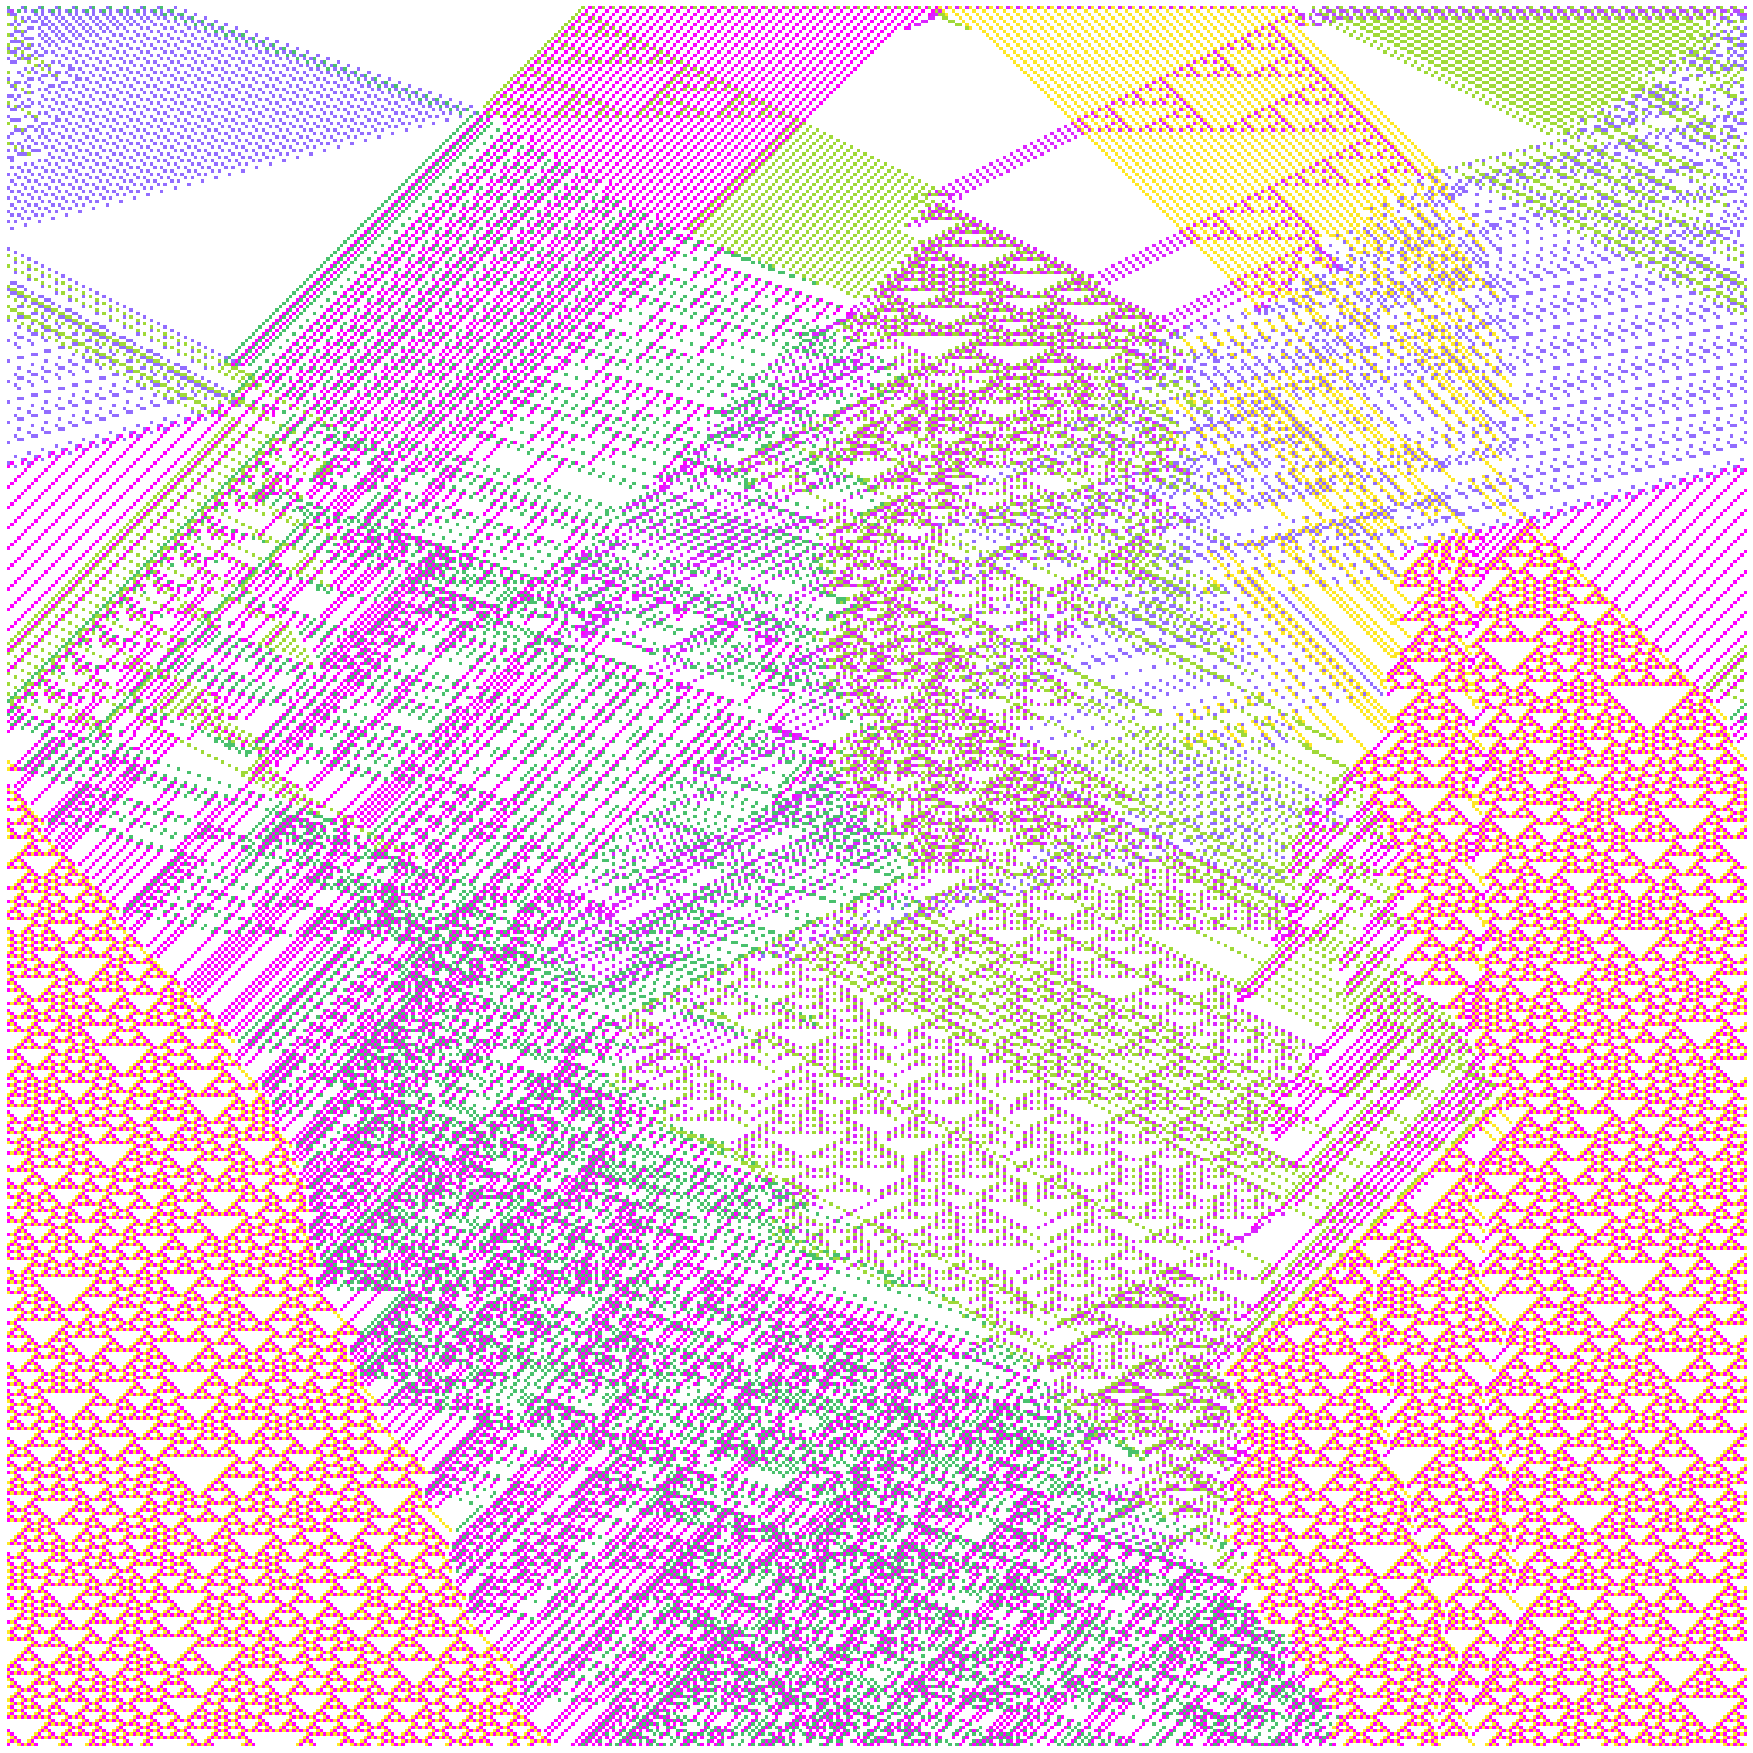

In [6]:
cmap = np.zeros((bc.gene_range, 4))
cmap[:bc.gene_max, :] = plt.cm.cool(np.linspace(0, 1, bc.gene_max))
cmap[(bc.gene_max + 1):, :] = plt.cm.viridis(np.linspace(0, 1, bc.gene_max))[::-1, :]
history_image = np.empty(bc.history.shape + tuple([4]))
for i, j in enumerate(range(bc.gene_min, bc.gene_max)):
    history_image[bc.history == j, :] = cmap[i, :]
    
fig, ax = plt.subplots(1, 1, figsize=(32, 32))
ax.imshow(history_image)
ax.set_axis_off()
